# Timelags

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
import distributed

from synthesizAR.analysis import AIATimelags, DistributedAIACube

from formatting import get_figsize, qualitative_palette

import warnings
warnings.filterwarnings('ignore',category=UserWarning,)

%matplotlib inline

In [2]:
channels = [94,131,171,193,211,335]
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]

In [3]:
cluster = distributed.LocalCluster(n_workers=64,threads_per_worker=1,)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:35319 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


## 1D Example

In [4]:
path_format = '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/nei/SDO_AIA/{c}/*.fits'

In [5]:
cooling = AIATimelags(*[DistributedAIACube.from_files(path_format.format(c=c)) for c in channels])

In [6]:
m = cooling[2].maps[500]

In [7]:
bc = SkyCoord(Tx=-315*u.arcsec,Ty=-335*u.arcsec,frame=m.coordinate_frame)
tc = SkyCoord(Tx=-310*u.arcsec,Ty=-330*u.arcsec,frame=m.coordinate_frame)

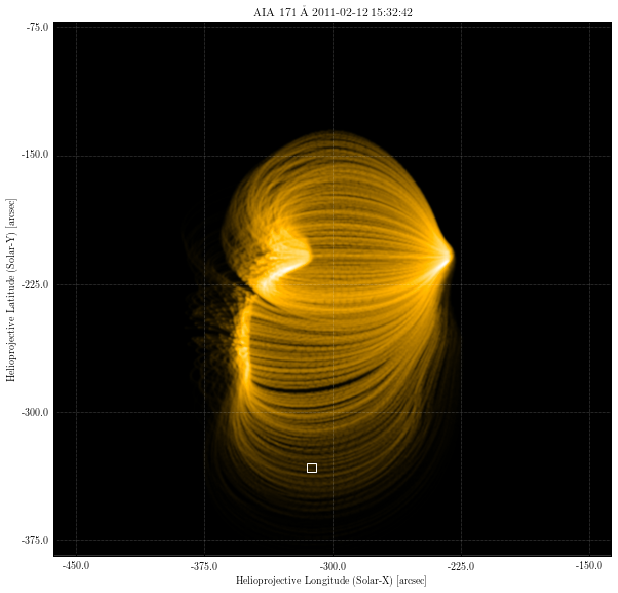

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=m)
m.plot()
m.draw_rectangle(bc, tc.Tx-bc.Tx, tc.Ty-bc.Ty,axes=ax)

In [17]:
np.array(channel_pairs)[[0,10,11]]

array([[ 94, 335],
       [211, 171],
       [211, 193]])

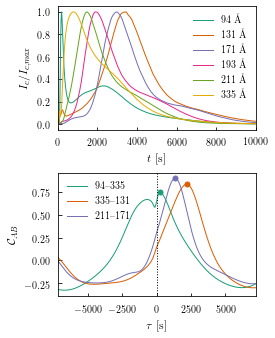

In [29]:
fig = plt.figure(figsize=get_figsize(wf=0.5,hf=1.5))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
plt.subplots_adjust(hspace=0.35)
colors = qualitative_palette(len(channels))
# Timeseries
for i,c in enumerate(channels[:]):
    ts = cooling.make_timeseries(c,(bc.Tx,bc.Ty),(tc.Tx,tc.Ty),)
    ts = ts/ts.max()#(ts - ts.mean()) / ts.std()
    ax1.plot(cooling[0].time, ts, label=f'${c}$ $\mathrm{{\AA}}$', color=colors[i])
ax1.legend(frameon=False,ncol=1,loc=1)#loc="lower left", bbox_to_anchor=(1.02,0))
ax1.set_ylim(-0.05,1.05)
ax1.set_xlim(0,cooling[0].time[-1].to(u.s).value)
ax1.set_xlabel(r'$t$ [s]')
ax1.set_ylabel(r'$I_{c}/I_{c,max}$')
# Cross-correlations
for i,(ca,cb) in enumerate(channel_pairs[::5]):
    cc = cooling.correlation_1d(ca, cb, (bc.Tx,bc.Ty), (tc.Tx,tc.Ty)).compute()
    ax2.plot(cooling.timelags, cc, label=f'${ca}$--${cb}$', color=colors[i])
    ax2.plot(cooling.timelags[cc.argmax()], cc.max(),marker='o',markersize=5,color=colors[i],ls='')
ax2.axvline(x=0,ls=':',color='k')
ax2.set_xlim(-(2*u.hour).to(u.s).value, (2*u.hour).to(u.s).value)
ax2.legend(frameon=False,ncol=1,loc=2)#loc="lower left",bbox_to_anchor=(1.02,.25))
ax2.set_ylabel(r'$\mathcal{C}_{AB}$')
ax2.set_xlabel(r'$\tau$ [s]')
fig.savefig('figures/correlation_1d_example.pdf')

## 2D Results